In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from IPython.display import display

import sys
import os
from pathlib import Path
import importlib

import nibabel as nib
import tqdm


In [8]:
merged_df = pd.read_csv("/gpfs/data/oermannlab/users/schula12/TumorMorph/all_fractal_morphology_features.csv")

In [15]:
# Add a binary response column to merged_df.
# If your response column is numeric (e.g., 3 = Response, 1/2 = PD/SD), use the lambda version:
merged_df["binary_response"] = merged_df["response"].apply(lambda x: 1 if x == 3 else 0)
print(merged_df["binary_response"].value_counts())
print("'binary_response' in merged_df columns?", 'binary_response' in merged_df.columns)



binary_response
1    157
0     78
Name: count, dtype: int64
'binary_response' in merged_df columns? True


# Ablation Study Results - Which combos are we doing (from Minimal -> to All Features)

In [1]:
# Numerical Clinical Features (replace 'sex_binary' if already done)
clinical_features_numerical = [
    'sex_numerical',
    'idh_wt_wild_type_numerical', 
    'mgmt_qualitative_numerical'
]

# Top Morph Features (high statistical signal)
top_morph_features = [
    'fractal_baseline_label_1', 'fractal_baseline_label_2', 'fractal_baseline_label_3',
    'fractal_followup_label_1', 'fractal_followup_label_2', 'fractal_followup_label_3',
    'fractal_label_1_change', 'fractal_label_1_volatility',
    'fractal_label_2_change', 'fractal_label_2_volatility',
    'fractal_label_3_change', 'fractal_label_3_volatility'
]

# Lesion Features
lesion_features = [
    "swin_net_total_lesion_change",
    "swin_enhancing_net_lesion_change",
    "swin_edema_net_lesion_change",
    "swin_necrotic_net_lesion_change"
]

# Baseline Morphology Features
baseline_morph_features = [
    "surface_area_baseline_whole", "compactness_baseline_whole",
    "fractal_baseline_whole", "lacunarity_baseline_whole"
]

# Volume Features
volume_delta_features = [
    "whole_tumor_volume_change", "whole_tumor_volume_volatility",
    "edema_volume_change", "edema_volume_volatility",
    "necrotic_volume_change", "necrotic_volume_volatility",
    "enhancing_volume_change", "enhancing_volume_volatility",
]

baseline_volume_features = [
    "baseline_swin_enhancing_volume", "baseline_swin_necrotic_volume",
    "baseline_swin_edema_volume", "baseline_swin_whole_tumor_volume"
]

# Define Ablation Setups
ablation_setups = {
    # Single types
    "Clinical only": clinical_features_numerical,
    "Volume ∆ only": volume_delta_features,
    "Baseline Volume only": baseline_volume_features,
    "Top Morph only": top_morph_features,
    "Lesion Morph only": lesion_features,
    #"Baseline Morph only": baseline_morph_features,

    # Pairs
    "Volume ∆ + Clinical": volume_delta_features + clinical_features_numerical,
    "Volume ∆ + Baseline Volume": volume_delta_features + baseline_volume_features,
    "Volume ∆ + Lesion": volume_delta_features + lesion_features,
    "Volume ∆ + Top Morph": volume_delta_features + top_morph_features,
    #"Baseline Vol + Clinical": baseline_volume_features + clinical_features_numerical,
    ##"Baseline Vol + Lesion": baseline_volume_features + lesion_features,
    #Baseline Vol + Top Morph": baseline_volume_features + top_morph_features,
    "Top Morph + Clinical": top_morph_features + clinical_features_numerical,
    #Lesion + Clinical": lesion_features + clinical_features_numerical,
    #"Baseline Morph + Clinical": baseline_morph_features + clinical_features_numerical,

    # Triads
    "Vol ∆ + Baseline Vol + Top Morph": volume_delta_features + baseline_volume_features + top_morph_features,
    "Vol ∆ + Lesion + Clinical": volume_delta_features + lesion_features + clinical_features_numerical,
    "Baseline Vol + Lesion + Top Morph": baseline_volume_features + lesion_features + top_morph_features,
    "Top Morph + Lesion + Clinical": top_morph_features + lesion_features + clinical_features_numerical,

    # All
    #"All features": volume_delta_features + baseline_volume_features + lesion_features + top_morph_features + baseline_morph_features + clinical_features_numerical
}


# Classic ML Models

In [4]:
# Add this cell at the top of your notebook:
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# Or specifically for LightGBM:
import lightgbm as lgb

# Define model setups
model_setups = {
    "RandomForest": (
        RandomForestClassifier(class_weight="balanced", random_state=42),
        {
            "clf__n_estimators": [50, 100],
            "clf__max_depth": [3, 5, None],
            "clf__min_samples_split": [2, 5],
            "clf__min_samples_leaf": [1, 2],
            "clf__max_features": ["sqrt", "log2"],
        }
    ),
    "LogisticRegression": (
        LogisticRegression(class_weight="balanced", solver="liblinear", max_iter=1000),
        {
            "clf__C": [0.01, 0.1, 1, 10],
            "clf__penalty": ["l1", "l2"]
        }
    ),
    "SVC (RBF)": (
        SVC(class_weight="balanced", probability=True),
        {
            "clf__C": [0.1, 1, 10],
            "clf__gamma": ["scale", "auto"]
        }
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
        {
            "clf__n_estimators": [50, 100],
            "clf__max_depth": [3, 5],
            "clf__learning_rate": [0.05, 0.1],
        }
    ),
    # In your model_setups, update the LightGBM configuration:

    "LightGBM": (
        LGBMClassifier(
            verbose=-1,           # Suppress all output
            objective='binary',   # Explicitly set objective
            boosting_type='gbdt', # Explicitly set boosting
            force_col_wise=True   # Remove threading overhead warning
        ),
        {
            "clf__n_estimators": [50, 100],
            "clf__num_leaves": [15, 31],
            "clf__learning_rate": [0.05, 0.1],
        }
)
}



# Classic ML training and ablation

In [16]:
from sklearn.model_selection import GroupShuffleSplit

def split_train_test_by_group(df, group_column="patient_id", test_size=0.2, random_state=42):
    """
    Splits a DataFrame into train and test sets by grouping on a patient or subject ID.
    Ensures no group (e.g., patient_id) appears in both train and test.

    Parameters:
        df (pd.DataFrame): The full dataset
        group_column (str): Column name to group by (usually "patient_id")
        test_size (float): Fraction of groups to assign to test set
        random_state (int): Seed for reproducibility

    Returns:
        df_train (pd.DataFrame), df_test (pd.DataFrame)
    """
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    groups = df[group_column]
    train_idx, test_idx = next(splitter.split(df, groups=groups))
    return df.iloc[train_idx].copy(), df.iloc[test_idx].copy()

df_train, df_test = split_train_test_by_group(merged_df)

# Sanity check for patient ID overlap
overlap = set(df_train["patient_id"]) & set(df_test["patient_id"])
print(f"❌ Overlapping patient_ids: {len(overlap)}" if overlap else "✅ No patient overlap — split is safe.")


✅ No patient overlap — split is safe.


In [10]:
print("\ndf_train head:")
print(list(df_train.columns))
df_train.head()


df_train head:
['patient_id', 'case_id', 'response', 'baseline_week', 'followup_week', 'time_difference_weeks', 'time_difference_days', 'baseline_gt_original_path', 'baseline_swin_path', 'followup_gt_original_path', 'followup_swin_path', 'baseline_gt_original_background_volume', 'baseline_gt_original_enhancing_volume', 'baseline_gt_original_necrotic_volume', 'baseline_gt_original_edema_volume', 'baseline_gt_original_enhancing_necrotic_volume', 'baseline_gt_original_all_tumor_volume', 'baseline_gt_original_whole_tumor_volume', 'baseline_swin_background_volume', 'baseline_swin_enhancing_volume', 'baseline_swin_necrotic_volume', 'baseline_swin_edema_volume', 'baseline_swin_enhancing_necrotic_volume', 'baseline_swin_all_tumor_volume', 'baseline_swin_whole_tumor_volume', 'followup_gt_original_background_volume', 'followup_gt_original_enhancing_volume', 'followup_gt_original_necrotic_volume', 'followup_gt_original_edema_volume', 'followup_gt_original_enhancing_necrotic_volume', 'followup_gt

,patient_id,case_id,response,baseline_week,followup_week,time_difference_weeks,time_difference_days,baseline_gt_original_path,baseline_swin_path,followup_gt_original_path,...,fractal_label_3_change_region,fractal_label_3_volatility_region,whole_tumor_volume_change_region,whole_tumor_volume_volatility_region,edema_volume_change_region,edema_volume_volatility_region,necrotic_volume_change_region,necrotic_volume_volatility_region,enhancing_volume_change_region,enhancing_volume_volatility_region
1,Patient-002,case_01,2,3,21,18,126,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,NaN,NaN,-65631,-3646.166667,-28380,-1576.666667,-26174,-1454.111111,-11077,-615.388889
2,Patient-002,case_02,3,3,37,34,238,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,0.150727,0.004433,-2300,-67.647059,13220,388.823529,-10558,-310.529412,-4962,-145.941176
3,Patient-002,case_03,3,40,47,7,49,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,NaN,NaN,40494,5784.857143,261,37.285714,7851,1121.571429,32382,4626.000000
4,Patient-003,case_01,2,0,14,14,98,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,-0.872895,-0.062350,-72346,-5167.571429,-39539,-2824.214286,-15652,-1118.000000,-17155,-1225.357143
5,Patient-003,case_02,3,0,27,27,189,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,NaN,NaN,-63369,-2347.000000,-36388,-1347.703704,-9572,-354.518519,-17409,-644.777778


In [17]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import os
import re
import json
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GridSearchCV, cross_validate
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from joblib import dump

results = []
all_test_predictions = []

# Ensure save directory exists
os.makedirs("saved_models", exist_ok=True)

# Outer loop for ablation setups
for setup_name, features in tqdm(ablation_setups.items(), desc="🔬 Ablation Setups"):
    df_clean = df_train.dropna(subset=features + ["binary_response", "patient_id"])
    X = df_clean[features]
    y = df_clean["binary_response"]
    groups = df_clean["patient_id"]

    print(f"\n📊 Evaluating setup: {setup_name} — {len(X)} samples")

    # Inner loop for each model
    for model_name, (model, param_grid) in tqdm(model_setups.items(), desc=f"⚙️ Models for {setup_name}", leave=False):
        print(f"\n🔍 Tuning model: {model_name}...")

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", model)
        ])

        gkf = GroupKFold(n_splits=5)

        # Grid search to find best hyperparameters
        grid = GridSearchCV(
            pipe, param_grid=param_grid,
            cv=gkf, scoring="f1_macro",
            n_jobs=-1, verbose=0
        )

        grid.fit(X, y, groups=groups)
        best_model = grid.best_estimator_

        # CORRECT EVALUATION: Get both train and validation scores from CV
        cv_results = cross_validate(
            best_model, X, y, 
            cv=gkf, 
            groups=groups, 
            scoring="f1_macro",
            return_train_score=True  # This is key!
        )

        # Proper CV metrics
        cv_train_f1 = np.mean(cv_results['train_score'])  # Training score within CV
        cv_val_f1 = np.mean(cv_results['test_score'])     # Validation score within CV
        cv_val_std = np.std(cv_results['test_score'])      # Standard deviation of CV validation scores

        # Refit on entire training set for final model
        best_model.fit(X, y)
        train_preds = best_model.predict(X)
        train_proba = best_model.predict_proba(X)[:, 1]
        
        # Full training set metrics (these should be very high - model has seen this data)
        train_f1_full = f1_score(y, train_preds, average='macro')
        train_roc_auc = roc_auc_score(y, train_proba)
        train_acc = accuracy_score(y, train_preds)

        # Test set evaluation (true holdout performance)
        df_test_clean = df_test.dropna(subset=features + ["binary_response", "patient_id"])
        X_test = df_test_clean[features]
        y_test = df_test_clean["binary_response"]

        y_test_pred = best_model.predict(X_test)
        y_test_proba = best_model.predict_proba(X_test)[:, 1]

        test_f1 = f1_score(y_test, y_test_pred, average='macro')
        test_roc_auc = roc_auc_score(y_test, y_test_proba)
        test_acc = accuracy_score(y_test, y_test_pred)

        # Calculate meaningful overfitting metrics
        cv_overfit_gap = cv_train_f1 - cv_val_f1  # Within CV
        generalization_gap = cv_val_f1 - test_f1   # CV to test set

        print(f"✅ {model_name}")
        print(f"   CV: Train F1={cv_train_f1:.4f}, Val F1={cv_val_f1:.4f} (±{cv_val_std:.4f})")
        print(f"   Test: F1={test_f1:.4f}, ROC-AUC={test_roc_auc:.4f}")
        print(f"   Overfitting: CV gap={cv_overfit_gap:.4f}, Generalization gap={generalization_gap:.4f}")

        # Record summary with CORRECTED metrics
        results.append({
            "Setup": setup_name,
            "Model": model_name,
            # Cross-validation metrics (most reliable for model selection)
            "CV_Val_F1": cv_val_f1,           # This is your main metric for comparing models
            "CV_Val_F1_std": cv_val_std,      # Variability across folds
            "CV_Train_F1": cv_train_f1,       # Training performance within CV
            "CV_Overfit_Gap": cv_overfit_gap, # cv_train - cv_val
            
            # Full training set metrics (after final refit)
            "Train_F1_Full": train_f1_full,   # Should be very high
            "Train_ROC_AUC": train_roc_auc,
            "Train_Accuracy": train_acc,
            
            # Test set metrics (true holdout)
            "Test_F1": test_f1,
            "Test_ROC_AUC": test_roc_auc,
            "Test_Accuracy": test_acc,
            
            # Generalization metrics
            "Generalization_Gap": generalization_gap,  # cv_val - test
            "Total_Overfit": cv_train_f1 - test_f1    # Total drop from CV train to test
        })

        # Save test predictions (optional)
        test_prediction_rows = pd.DataFrame({
            "patient_id": df_test_clean["patient_id"].values,
            "true_label": y_test,
            "pred_label": y_test_pred,
            "pred_proba": y_test_proba,
            "model": model_name,
            "setup": setup_name
        })
        all_test_predictions.append(test_prediction_rows)

        # === SAVE BEST MODEL + PARAMS ===
        clean_setup = re.sub(r"[^a-zA-Z0-9]+", "_", setup_name)
        clean_model = re.sub(r"[^a-zA-Z0-9]+", "_", model_name)

        base_name = f"{clean_setup}_{clean_model}"
        model_path = f"saved_models/model_{base_name}.joblib"
        param_path = f"saved_models/params_{base_name}.json"
        metrics_path = f"saved_models/metrics_{base_name}.json"

        # Save model
        dump(best_model, model_path)

        # Save parameters
        with open(param_path, "w") as f:
            json.dump(grid.best_params_, f, indent=4)
        
        # Save metrics for this specific model
        model_metrics = {
            "setup": setup_name,
            "model": model_name,
            "best_params": grid.best_params_,
            "cv_val_f1": cv_val_f1,
            "cv_train_f1": cv_train_f1,
            "test_f1": test_f1,
            "test_roc_auc": test_roc_auc,
            "cv_overfit_gap": cv_overfit_gap,
            "generalization_gap": generalization_gap
        }
        with open(metrics_path, "w") as f:
            json.dump(model_metrics, f, indent=4)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save results
results_df.to_csv("ablation_results_1.csv", index=False)
print(f"\n📊 Results saved to 'ablation_results_1.csv'")

# Save all test predictions
if all_test_predictions:
    all_test_preds_df = pd.concat(all_test_predictions, ignore_index=True)
    all_test_preds_df.to_csv("all_test_predictions_1.csv", index=False)
    print(f"🎯 Test predictions saved to 'all_test_predictions_1.csv'")

# Print summary statistics
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

# Best models by CV validation F1
best_by_cv = results_df.nlargest(5, 'CV_Val_F1')[['Setup', 'Model', 'CV_Val_F1', 'Test_F1', 'CV_Overfit_Gap']]
print("\nTop 5 Models by Cross-Validation F1:")
print(best_by_cv.to_string(index=False))

# Check for any remaining anomalies
anomalies = results_df[results_df['Test_F1'] > results_df['CV_Train_F1']]
if len(anomalies) > 0:
    print(f"\n⚠️ WARNING: {len(anomalies)} cases where Test > CV_Train (investigate these)")
    print(anomalies[['Model', 'Setup', 'CV_Train_F1', 'Test_F1']].head())
else:
    print("\n✅ No anomalies detected (Test never exceeds CV Train)")

# Overall statistics
print(f"\nOverall Performance:")
print(f"  Avg CV Val F1: {results_df['CV_Val_F1'].mean():.3f} (±{results_df['CV_Val_F1'].std():.3f})")
print(f"  Avg Test F1: {results_df['Test_F1'].mean():.3f} (±{results_df['Test_F1'].std():.3f})")
print(f"  Avg CV Overfitting: {results_df['CV_Overfit_Gap'].mean():.3f}")
print(f"  Avg Generalization Gap: {results_df['Generalization_Gap'].mean():.3f}")

🔬 Ablation Setups:   0%|          | 0/14 [00:00<?, ?it/s]


📊 Evaluating setup: Clinical only — 182 samples



🔍 Tuning model: RandomForest...


✅ RandomForest
   CV: Train F1=0.6737, Val F1=0.6093 (±0.1020)
   Test: F1=0.4952, ROC-AUC=0.4625
   Overfitting: CV gap=0.0644, Generalization gap=0.1140

🔍 Tuning model: LogisticRegression...
✅ LogisticRegression
   CV: Train F1=0.6428, Val F1=0.6261 (±0.1016)
   Test: F1=0.5095, ROC-AUC=0.4817
   Overfitting: CV gap=0.0167, Generalization gap=0.1167



🔍 Tuning model: SVC (RBF)...


✅ SVC (RBF)
   CV: Train F1=0.6452, Val F1=0.6111 (±0.1205)
   Test: F1=0.4301, ROC-AUC=0.5010
   Overfitting: CV gap=0.0341, Generalization gap=0.1810

🔍 Tuning model: XGBoost...


✅ XGBoost
   CV: Train F1=0.6573, Val F1=0.5967 (±0.1075)
   Test: F1=0.4301, ROC-AUC=0.4529
   Overfitting: CV gap=0.0606, Generalization gap=0.1666

🔍 Tuning model: LightGBM...


🔬 Ablation Setups:   7%|▋         | 1/14 [00:22<04:48, 22.23s/it]

✅ LightGBM
   CV: Train F1=0.6591, Val F1=0.6257 (±0.0996)
   Test: F1=0.4301, ROC-AUC=0.3942
   Overfitting: CV gap=0.0334, Generalization gap=0.1956

📊 Evaluating setup: Volume ∆ only — 182 samples



🔍 Tuning model: RandomForest...


✅ RandomForest
   CV: Train F1=0.9324, Val F1=0.6468 (±0.0720)
   Test: F1=0.5604, ROC-AUC=0.6500
   Overfitting: CV gap=0.2856, Generalization gap=0.0864

🔍 Tuning model: LogisticRegression...


✅ LogisticRegression
   CV: Train F1=0.6522, Val F1=0.5786 (±0.0657)
   Test: F1=0.4876, ROC-AUC=0.6865
   Overfitting: CV gap=0.0736, Generalization gap=0.0910

🔍 Tuning model: SVC (RBF)...


✅ SVC (RBF)
   CV: Train F1=0.7262, Val F1=0.6146 (±0.1146)
   Test: F1=0.5500, ROC-AUC=0.6673
   Overfitting: CV gap=0.1116, Generalization gap=0.0646

🔍 Tuning model: XGBoost...


✅ XGBoost
   CV: Train F1=0.8882, Val F1=0.5915 (±0.0936)
   Test: F1=0.5971, ROC-AUC=0.7106
   Overfitting: CV gap=0.2967, Generalization gap=-0.0056

🔍 Tuning model: LightGBM...


🔬 Ablation Setups:  14%|█▍        | 2/14 [00:45<04:32, 22.68s/it]

✅ LightGBM
   CV: Train F1=0.8903, Val F1=0.5992 (±0.0198)
   Test: F1=0.5213, ROC-AUC=0.6885
   Overfitting: CV gap=0.2911, Generalization gap=0.0779

📊 Evaluating setup: Baseline Volume only — 182 samples



🔍 Tuning model: RandomForest...


✅ RandomForest
   CV: Train F1=0.7158, Val F1=0.4908 (±0.0969)
   Test: F1=0.3358, ROC-AUC=0.4337
   Overfitting: CV gap=0.2250, Generalization gap=0.1550

🔍 Tuning model: LogisticRegression...
✅ LogisticRegression
   CV: Train F1=0.5102, Val F1=0.4498 (±0.0365)
   Test: F1=0.4840, ROC-AUC=0.6510
   Overfitting: CV gap=0.0605, Generalization gap=-0.0342



🔍 Tuning model: SVC (RBF)...


✅ SVC (RBF)
   CV: Train F1=0.6373, Val F1=0.5620 (±0.0977)
   Test: F1=0.3471, ROC-AUC=0.4683
   Overfitting: CV gap=0.0754, Generalization gap=0.2149

🔍 Tuning model: XGBoost...


✅ XGBoost
   CV: Train F1=0.8113, Val F1=0.4130 (±0.0839)
   Test: F1=0.3270, ROC-AUC=0.3067
   Overfitting: CV gap=0.3983, Generalization gap=0.0860

🔍 Tuning model: LightGBM...


🔬 Ablation Setups:  21%|██▏       | 3/14 [01:06<04:01, 21.96s/it]

✅ LightGBM
   CV: Train F1=0.6866, Val F1=0.4538 (±0.0604)
   Test: F1=0.4504, ROC-AUC=0.4952
   Overfitting: CV gap=0.2328, Generalization gap=0.0034

📊 Evaluating setup: Top Morph only — 73 samples



🔍 Tuning model: RandomForest...


✅ RandomForest
   CV: Train F1=0.9717, Val F1=0.6811 (±0.1925)
   Test: F1=0.4762, ROC-AUC=0.4398
   Overfitting: CV gap=0.2905, Generalization gap=0.2050

🔍 Tuning model: LogisticRegression...


✅ LogisticRegression
   CV: Train F1=0.8020, Val F1=0.6739 (±0.1161)
   Test: F1=0.7381, ROC-AUC=0.8565
   Overfitting: CV gap=0.1281, Generalization gap=-0.0642

🔍 Tuning model: SVC (RBF)...


✅ SVC (RBF)
   CV: Train F1=0.9843, Val F1=0.6039 (±0.1567)
   Test: F1=0.5387, ROC-AUC=0.4907
   Overfitting: CV gap=0.3804, Generalization gap=0.0652

🔍 Tuning model: XGBoost...


✅ XGBoost
   CV: Train F1=1.0000, Val F1=0.6666 (±0.1957)
   Test: F1=0.5460, ROC-AUC=0.5648
   Overfitting: CV gap=0.3334, Generalization gap=0.1205

🔍 Tuning model: LightGBM...


🔬 Ablation Setups:  29%|██▊       | 4/14 [01:27<03:35, 21.53s/it]

✅ LightGBM
   CV: Train F1=0.7832, Val F1=0.5557 (±0.1647)
   Test: F1=0.5255, ROC-AUC=0.5556
   Overfitting: CV gap=0.2275, Generalization gap=0.0302

📊 Evaluating setup: Lesion Morph only — 182 samples



🔍 Tuning model: RandomForest...


✅ RandomForest
   CV: Train F1=0.7357, Val F1=0.6192 (±0.0801)
   Test: F1=0.4840, ROC-AUC=0.5981
   Overfitting: CV gap=0.1166, Generalization gap=0.1352

🔍 Tuning model: LogisticRegression...
✅ LogisticRegression
   CV: Train F1=0.5838, Val F1=0.5771 (±0.0870)
   Test: F1=0.4700, ROC-AUC=0.6635
   Overfitting: CV gap=0.0068, Generalization gap=0.1071



🔍 Tuning model: SVC (RBF)...


✅ SVC (RBF)
   CV: Train F1=0.6654, Val F1=0.6267 (±0.0952)
   Test: F1=0.5222, ROC-AUC=0.6135
   Overfitting: CV gap=0.0386, Generalization gap=0.1046

🔍 Tuning model: XGBoost...


✅ XGBoost
   CV: Train F1=0.7551, Val F1=0.5103 (±0.0877)
   Test: F1=0.5147, ROC-AUC=0.5788
   Overfitting: CV gap=0.2448, Generalization gap=-0.0043

🔍 Tuning model: LightGBM...


🔬 Ablation Setups:  36%|███▌      | 5/14 [01:48<03:12, 21.36s/it]

✅ LightGBM
   CV: Train F1=0.6935, Val F1=0.4959 (±0.0717)
   Test: F1=0.6942, ROC-AUC=0.7269
   Overfitting: CV gap=0.1976, Generalization gap=-0.1983

📊 Evaluating setup: Volume ∆ + Clinical — 182 samples



🔍 Tuning model: RandomForest...


✅ RandomForest
   CV: Train F1=0.9498, Val F1=0.6905 (±0.0406)
   Test: F1=0.6801, ROC-AUC=0.7519
   Overfitting: CV gap=0.2593, Generalization gap=0.0104

🔍 Tuning model: LogisticRegression...


✅ LogisticRegression
   CV: Train F1=0.7126, Val F1=0.6634 (±0.0699)
   Test: F1=0.5488, ROC-AUC=0.7173
   Overfitting: CV gap=0.0492, Generalization gap=0.1146

🔍 Tuning model: SVC (RBF)...


✅ SVC (RBF)
   CV: Train F1=0.7709, Val F1=0.6797 (±0.0446)
   Test: F1=0.5985, ROC-AUC=0.6596
   Overfitting: CV gap=0.0912, Generalization gap=0.0812

🔍 Tuning model: XGBoost...


✅ XGBoost
   CV: Train F1=0.8848, Val F1=0.7011 (±0.0371)
   Test: F1=0.6558, ROC-AUC=0.7837
   Overfitting: CV gap=0.1838, Generalization gap=0.0452

🔍 Tuning model: LightGBM...


🔬 Ablation Setups:  43%|████▎     | 6/14 [02:11<02:55, 21.98s/it]

✅ LightGBM
   CV: Train F1=0.8498, Val F1=0.6778 (±0.0570)
   Test: F1=0.5691, ROC-AUC=0.7135
   Overfitting: CV gap=0.1720, Generalization gap=0.1087

📊 Evaluating setup: Volume ∆ + Baseline Volume — 182 samples



🔍 Tuning model: RandomForest...


✅ RandomForest
   CV: Train F1=0.8482, Val F1=0.6228 (±0.0791)
   Test: F1=0.4898, ROC-AUC=0.7135
   Overfitting: CV gap=0.2254, Generalization gap=0.1330

🔍 Tuning model: LogisticRegression...


✅ LogisticRegression
   CV: Train F1=0.6568, Val F1=0.5421 (±0.0726)
   Test: F1=0.4876, ROC-AUC=0.7327
   Overfitting: CV gap=0.1147, Generalization gap=0.0544

🔍 Tuning model: SVC (RBF)...


✅ SVC (RBF)
   CV: Train F1=0.7546, Val F1=0.5668 (±0.1210)
   Test: F1=0.5335, ROC-AUC=0.6673
   Overfitting: CV gap=0.1878, Generalization gap=0.0333

🔍 Tuning model: XGBoost...


✅ XGBoost
   CV: Train F1=1.0000, Val F1=0.5724 (±0.1063)
   Test: F1=0.5521, ROC-AUC=0.6519
   Overfitting: CV gap=0.4276, Generalization gap=0.0203

🔍 Tuning model: LightGBM...


🔬 Ablation Setups:  50%|█████     | 7/14 [02:34<02:36, 22.31s/it]

✅ LightGBM
   CV: Train F1=0.9181, Val F1=0.5884 (±0.0507)
   Test: F1=0.5426, ROC-AUC=0.7077
   Overfitting: CV gap=0.3297, Generalization gap=0.0458

📊 Evaluating setup: Volume ∆ + Lesion — 182 samples



🔍 Tuning model: RandomForest...


✅ RandomForest
   CV: Train F1=0.9265, Val F1=0.6418 (±0.0912)
   Test: F1=0.6057, ROC-AUC=0.6558
   Overfitting: CV gap=0.2848, Generalization gap=0.0361

🔍 Tuning model: LogisticRegression...
✅ LogisticRegression
   CV: Train F1=0.6725, Val F1=0.6019 (±0.0752)
   Test: F1=0.5726, ROC-AUC=0.7365
   Overfitting: CV gap=0.0707, Generalization gap=0.0293



🔍 Tuning model: SVC (RBF)...


✅ SVC (RBF)
   CV: Train F1=0.7929, Val F1=0.6660 (±0.0768)
   Test: F1=0.5173, ROC-AUC=0.6962
   Overfitting: CV gap=0.1270, Generalization gap=0.1486

🔍 Tuning model: XGBoost...


✅ XGBoost
   CV: Train F1=0.9593, Val F1=0.6479 (±0.0673)
   Test: F1=0.5147, ROC-AUC=0.6346
   Overfitting: CV gap=0.3115, Generalization gap=0.1332

🔍 Tuning model: LightGBM...


🔬 Ablation Setups:  57%|█████▋    | 8/14 [02:56<02:13, 22.26s/it]

✅ LightGBM
   CV: Train F1=0.9805, Val F1=0.6275 (±0.0525)
   Test: F1=0.5351, ROC-AUC=0.6827
   Overfitting: CV gap=0.3530, Generalization gap=0.0924

📊 Evaluating setup: Volume ∆ + Top Morph — 73 samples



🔍 Tuning model: RandomForest...


✅ RandomForest
   CV: Train F1=1.0000, Val F1=0.6145 (±0.1722)
   Test: F1=0.5417, ROC-AUC=0.4931
   Overfitting: CV gap=0.3855, Generalization gap=0.0729

🔍 Tuning model: LogisticRegression...


✅ LogisticRegression
   CV: Train F1=0.7079, Val F1=0.6240 (±0.1324)
   Test: F1=0.7102, ROC-AUC=0.7824
   Overfitting: CV gap=0.0840, Generalization gap=-0.0863

🔍 Tuning model: SVC (RBF)...


✅ SVC (RBF)
   CV: Train F1=0.8382, Val F1=0.5504 (±0.1313)
   Test: F1=0.6726, ROC-AUC=0.6389
   Overfitting: CV gap=0.2878, Generalization gap=-0.1222

🔍 Tuning model: XGBoost...


✅ XGBoost
   CV: Train F1=1.0000, Val F1=0.6968 (±0.1223)
   Test: F1=0.5662, ROC-AUC=0.5486
   Overfitting: CV gap=0.3032, Generalization gap=0.1305

🔍 Tuning model: LightGBM...


🔬 Ablation Setups:  64%|██████▍   | 9/14 [03:16<01:48, 21.66s/it]

✅ LightGBM
   CV: Train F1=0.8885, Val F1=0.5480 (±0.1012)
   Test: F1=0.4261, ROC-AUC=0.4444
   Overfitting: CV gap=0.3405, Generalization gap=0.1220

📊 Evaluating setup: Top Morph + Clinical — 73 samples



🔍 Tuning model: RandomForest...


✅ RandomForest
   CV: Train F1=1.0000, Val F1=0.7643 (±0.1460)
   Test: F1=0.4731, ROC-AUC=0.3935
   Overfitting: CV gap=0.2357, Generalization gap=0.2911

🔍 Tuning model: LogisticRegression...
✅ LogisticRegression
   CV: Train F1=0.8137, Val F1=0.7610 (±0.1448)
   Test: F1=0.6118, ROC-AUC=0.7454
   Overfitting: CV gap=0.0527, Generalization gap=0.1493



🔍 Tuning model: SVC (RBF)...


✅ SVC (RBF)
   CV: Train F1=0.9655, Val F1=0.7154 (±0.1385)
   Test: F1=0.6700, ROC-AUC=0.7176
   Overfitting: CV gap=0.2501, Generalization gap=0.0454

🔍 Tuning model: XGBoost...


✅ XGBoost
   CV: Train F1=1.0000, Val F1=0.7189 (±0.1043)
   Test: F1=0.4907, ROC-AUC=0.5463
   Overfitting: CV gap=0.2811, Generalization gap=0.2282

🔍 Tuning model: LightGBM...


🔬 Ablation Setups:  71%|███████▏  | 10/14 [03:37<01:25, 21.28s/it]

✅ LightGBM
   CV: Train F1=0.8163, Val F1=0.6040 (±0.1292)
   Test: F1=0.4731, ROC-AUC=0.5347
   Overfitting: CV gap=0.2123, Generalization gap=0.1308

📊 Evaluating setup: Vol ∆ + Baseline Vol + Top Morph — 73 samples



🔍 Tuning model: RandomForest...


✅ RandomForest
   CV: Train F1=0.9881, Val F1=0.6927 (±0.1365)
   Test: F1=0.4545, ROC-AUC=0.5694
   Overfitting: CV gap=0.2954, Generalization gap=0.2382

🔍 Tuning model: LogisticRegression...
✅ LogisticRegression
   CV: Train F1=0.8779, Val F1=0.6811 (±0.1620)
   Test: F1=0.6459, ROC-AUC=0.7546
   Overfitting: CV gap=0.1968, Generalization gap=0.0352



🔍 Tuning model: SVC (RBF)...
✅ SVC (RBF)
   CV: Train F1=0.8207, Val F1=0.5531 (±0.1487)
   Test: F1=0.4221, ROC-AUC=0.5046
   Overfitting: CV gap=0.2676, Generalization gap=0.1309



🔍 Tuning model: XGBoost...


✅ XGBoost
   CV: Train F1=1.0000, Val F1=0.6752 (±0.1733)
   Test: F1=0.6159, ROC-AUC=0.5833
   Overfitting: CV gap=0.3248, Generalization gap=0.0593

🔍 Tuning model: LightGBM...


🔬 Ablation Setups:  79%|███████▊  | 11/14 [03:57<01:03, 21.08s/it]

✅ LightGBM
   CV: Train F1=0.9119, Val F1=0.5479 (±0.1134)
   Test: F1=0.5875, ROC-AUC=0.5648
   Overfitting: CV gap=0.3641, Generalization gap=-0.0396

📊 Evaluating setup: Vol ∆ + Lesion + Clinical — 182 samples



🔍 Tuning model: RandomForest...


✅ RandomForest
   CV: Train F1=0.9852, Val F1=0.6659 (±0.0515)
   Test: F1=0.5965, ROC-AUC=0.7327
   Overfitting: CV gap=0.3192, Generalization gap=0.0694

🔍 Tuning model: LogisticRegression...
✅ LogisticRegression
   CV: Train F1=0.7221, Val F1=0.6482 (±0.0652)
   Test: F1=0.6146, ROC-AUC=0.7692
   Overfitting: CV gap=0.0739, Generalization gap=0.0335



🔍 Tuning model: SVC (RBF)...


✅ SVC (RBF)
   CV: Train F1=0.8881, Val F1=0.7209 (±0.0761)
   Test: F1=0.6581, ROC-AUC=0.7538
   Overfitting: CV gap=0.1671, Generalization gap=0.0629

🔍 Tuning model: XGBoost...


✅ XGBoost
   CV: Train F1=0.9454, Val F1=0.6770 (±0.0529)
   Test: F1=0.5923, ROC-AUC=0.7135
   Overfitting: CV gap=0.2684, Generalization gap=0.0847

🔍 Tuning model: LightGBM...


🔬 Ablation Setups:  86%|████████▌ | 12/14 [04:19<00:42, 21.35s/it]

✅ LightGBM
   CV: Train F1=0.8528, Val F1=0.6752 (±0.0643)
   Test: F1=0.6558, ROC-AUC=0.7913
   Overfitting: CV gap=0.1776, Generalization gap=0.0194

📊 Evaluating setup: Baseline Vol + Lesion + Top Morph — 73 samples



🔍 Tuning model: RandomForest...


✅ RandomForest
   CV: Train F1=0.9958, Val F1=0.7367 (±0.1753)
   Test: F1=0.5196, ROC-AUC=0.5694
   Overfitting: CV gap=0.2590, Generalization gap=0.2171

🔍 Tuning model: LogisticRegression...


✅ LogisticRegression
   CV: Train F1=0.8364, Val F1=0.6891 (±0.1442)
   Test: F1=0.7556, ROC-AUC=0.8565
   Overfitting: CV gap=0.1473, Generalization gap=-0.0665

🔍 Tuning model: SVC (RBF)...


✅ SVC (RBF)
   CV: Train F1=0.9676, Val F1=0.5616 (±0.1251)
   Test: F1=0.5558, ROC-AUC=0.5833
   Overfitting: CV gap=0.4059, Generalization gap=0.0059

🔍 Tuning model: XGBoost...


✅ XGBoost
   CV: Train F1=1.0000, Val F1=0.6864 (±0.2010)
   Test: F1=0.6118, ROC-AUC=0.6204
   Overfitting: CV gap=0.3136, Generalization gap=0.0746

🔍 Tuning model: LightGBM...


🔬 Ablation Setups:  93%|█████████▎| 13/14 [04:41<00:21, 21.28s/it]

✅ LightGBM
   CV: Train F1=0.8438, Val F1=0.6318 (±0.1762)
   Test: F1=0.5091, ROC-AUC=0.6157
   Overfitting: CV gap=0.2119, Generalization gap=0.1227

📊 Evaluating setup: Top Morph + Lesion + Clinical — 73 samples



🔍 Tuning model: RandomForest...
✅ RandomForest
   CV: Train F1=0.9962, Val F1=0.7194 (±0.1783)
   Test: F1=0.4731, ROC-AUC=0.5185
   Overfitting: CV gap=0.2767, Generalization gap=0.2463



🔍 Tuning model: LogisticRegression...


✅ LogisticRegression
   CV: Train F1=0.8665, Val F1=0.7170 (±0.1368)
   Test: F1=0.6435, ROC-AUC=0.7917
   Overfitting: CV gap=0.1495, Generalization gap=0.0736

🔍 Tuning model: SVC (RBF)...


✅ SVC (RBF)
   CV: Train F1=0.9074, Val F1=0.7063 (±0.1025)
   Test: F1=0.5926, ROC-AUC=0.6991
   Overfitting: CV gap=0.2011, Generalization gap=0.1137

🔍 Tuning model: XGBoost...


✅ XGBoost
   CV: Train F1=0.9859, Val F1=0.6653 (±0.1546)
   Test: F1=0.5091, ROC-AUC=0.6296
   Overfitting: CV gap=0.3205, Generalization gap=0.1562

🔍 Tuning model: LightGBM...


🔬 Ablation Setups: 100%|██████████| 14/14 [05:02<00:00, 21.60s/it]

✅ LightGBM
   CV: Train F1=0.8908, Val F1=0.5399 (±0.1007)
   Test: F1=0.5091, ROC-AUC=0.4491
   Overfitting: CV gap=0.3510, Generalization gap=0.0308

📊 Results saved to 'ablation_results_1.csv'
🎯 Test predictions saved to 'all_test_predictions_1.csv'

FINAL SUMMARY

Top 5 Models by Cross-Validation F1:
                            Setup              Model  CV_Val_F1  Test_F1  CV_Overfit_Gap
             Top Morph + Clinical       RandomForest   0.764271 0.473149        0.235729
             Top Morph + Clinical LogisticRegression   0.761023 0.611765        0.052693
Baseline Vol + Lesion + Top Morph       RandomForest   0.736723 0.519597        0.259041
        Vol ∆ + Lesion + Clinical          SVC (RBF)   0.720943 0.658065        0.167136
    Top Morph + Lesion + Clinical       RandomForest   0.719429 0.473149        0.276742

⚠️ WARNING: 2 cases where Test > CV_Train (investigate these)
                 Model                 Setup  CV_Train_F1   Test_F1
24            LightGBM     Le

In [88]:
additional_ablations = {
    # The likely winner
    "Vol ∆ + Top Morph + Clinical": 
        volume_delta_features + top_morph_features + clinical_features_numerical,
    
    # Pure morphology validation  
    "Top Morph + Lesion": 
        top_morph_features + lesion_features,
    
    # Test volatility alone
    "Volatility only": [
        'fractal_whole_volatility',
        'lacunarity_whole_volatility',
        'whole_tumor_volume_volatility',
        'edema_volume_volatility',
        'necrotic_volume_volatility',
        'enhancing_volume_volatility'
    ],
    
    # All temporal, no baseline
    "All Temporal": 
        volume_delta_features + top_morph_features + lesion_features + clinical_features_numerical
}

In [ ]:
def run_ablation_pipeline(
    ablation_setups,
    model_setups,
    df_train,
    df_test,
    save_prefix="1",
    results_dir="saved_models"
):
    from tqdm import tqdm
    import os, re, json
    import numpy as np
    import pandas as pd
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import GroupKFold, GridSearchCV, cross_validate
    from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
    from joblib import dump

    os.makedirs(results_dir, exist_ok=True)
    results = []
    all_test_predictions = []

    for setup_name, features in tqdm(ablation_setups.items(), desc="🔬 Ablation Setups"):
        df_clean = df_train.dropna(subset=features + ["response", "patient_id"])
        X = df_clean[features]
        y = df_clean["binary_response"]
        groups = df_clean["patient_id"]

        print(f"\n📊 Evaluating setup: {setup_name} — {len(X)} samples")

        for model_name, (model, param_grid) in tqdm(model_setups.items(), desc=f"⚙️ Models for {setup_name}", leave=False):
            print(f"\n🔍 Tuning model: {model_name}...")

            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("clf", model)
            ])

            gkf = GroupKFold(n_splits=5)

            grid = GridSearchCV(pipe, param_grid=param_grid, cv=gkf, scoring="f1_macro", n_jobs=-1, verbose=0)
            grid.fit(X, y, groups=groups)
            best_model = grid.best_estimator_

            cv_results = cross_validate(
                best_model, X, y, cv=gkf, groups=groups,
                scoring="f1_macro", return_train_score=True
            )

            cv_train_f1 = np.mean(cv_results['train_score'])
            cv_val_f1 = np.mean(cv_results['test_score'])
            cv_val_std = np.std(cv_results['test_score'])

            best_model.fit(X, y)
            train_preds = best_model.predict(X)
            train_proba = best_model.predict_proba(X)[:, 1]

            train_f1_full = f1_score(y, train_preds, average='macro')
            train_roc_auc = roc_auc_score(y, train_proba)
            train_acc = accuracy_score(y, train_preds)

            df_test_clean = df_test.dropna(subset=features + ["binary_response", "patient_id"])
            X_test = df_test_clean[features]
            y_test = df_test_clean["binary_response"]

            y_test_pred = best_model.predict(X_test)
            y_test_proba = best_model.predict_proba(X_test)[:, 1]

            test_f1 = f1_score(y_test, y_test_pred, average='macro')
            test_roc_auc = roc_auc_score(y_test, y_test_proba)
            test_acc = accuracy_score(y_test, y_test_pred)

            cv_overfit_gap = cv_train_f1 - cv_val_f1
            generalization_gap = cv_val_f1 - test_f1

            print(f"✅ {model_name}")
            print(f"   CV: Train F1={cv_train_f1:.4f}, Val F1={cv_val_f1:.4f} (±{cv_val_std:.4f})")
            print(f"   Test: F1={test_f1:.4f}, ROC-AUC={test_roc_auc:.4f}")
            print(f"   Overfitting: CV gap={cv_overfit_gap:.4f}, Generalization gap={generalization_gap:.4f}")

            results.append({
                "Setup": setup_name,
                "Model": model_name,
                "CV_Val_F1": cv_val_f1,
                "CV_Val_F1_std": cv_val_std,
                "CV_Train_F1": cv_train_f1,
                "CV_Overfit_Gap": cv_overfit_gap,
                "Train_F1_Full": train_f1_full,
                "Train_ROC_AUC": train_roc_auc,
                "Train_Accuracy": train_acc,
                "Test_F1": test_f1,
                "Test_ROC_AUC": test_roc_auc,
                "Test_Accuracy": test_acc,
                "Generalization_Gap": generalization_gap,
                "Total_Overfit": cv_train_f1 - test_f1
            })

            test_prediction_rows = pd.DataFrame({
                "patient_id": df_test_clean["patient_id"].values,
                "true_label": y_test,
                "pred_label": y_test_pred,
                "pred_proba": y_test_proba,
                "model": model_name,
                "setup": setup_name
            })
            all_test_predictions.append(test_prediction_rows)

            # Save paths
            clean_setup = re.sub(r"[^a-zA-Z0-9]+", "_", setup_name)
            clean_model = re.sub(r"[^a-zA-Z0-9]+", "_", model_name)
            base_name = f"{clean_setup}_{clean_model}_{save_prefix}"

            dump(best_model, os.path.join(results_dir, f"model_{base_name}.joblib"))
            with open(os.path.join(results_dir, f"params_{base_name}.json"), "w") as f:
                json.dump(grid.best_params_, f, indent=4)
            with open(os.path.join(results_dir, f"metrics_{base_name}.json"), "w") as f:
                json.dump({
                    "setup": setup_name,
                    "model": model_name,
                    "best_params": grid.best_params_,
                    "cv_val_f1": cv_val_f1,
                    "cv_train_f1": cv_train_f1,
                    "test_f1": test_f1,
                    "test_roc_auc": test_roc_auc,
                    "cv_overfit_gap": cv_overfit_gap,
                    "generalization_gap": generalization_gap
                }, f, indent=4)

    # Final results dataframe
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"ablation_results_{save_prefix}.csv", index=False)
    print(f"\n📊 Results saved to 'ablation_results_{save_prefix}.csv'")

    if all_test_predictions:
        all_preds_df = pd.concat(all_test_predictions, ignore_index=True)
        all_preds_df.to_csv(f"all_test_predictions_{save_prefix}.csv", index=False)
        print(f"🎯 Test predictions saved to 'all_test_predictions_{save_prefix}.csv'")

    # Summary
    print("\n" + "="*60)
    print("FINAL SUMMARY")
    print("="*60)

    best_by_cv = results_df.nlargest(5, 'CV_Val_F1')[['Setup', 'Model', 'CV_Val_F1', 'Test_F1', 'CV_Overfit_Gap']]
    print("\nTop 5 Models by Cross-Validation F1:")
    print(best_by_cv.to_string(index=False))

    anomalies = results_df[results_df['Test_F1'] > results_df['CV_Train_F1']]
    if len(anomalies) > 0:
        print(f"\n⚠️ WARNING: {len(anomalies)} cases where Test > CV_Train (investigate these)")
        print(anomalies[['Model', 'Setup', 'CV_Train_F1', 'Test_F1']].head())
    else:
        print("\n✅ No anomalies detected (Test never exceeds CV Train)")

    print(f"\nOverall Performance:")
    print(f"  Avg CV Val F1: {results_df['CV_Val_F1'].mean():.3f} (±{results_df['CV_Val_F1'].std():.3f})")
    print(f"  Avg Test F1: {results_df['Test_F1'].mean():.3f} (±{results_df['Test_F1'].std():.3f})")
    print(f"  Avg CV Overfitting: {results_df['CV_Overfit_Gap'].mean():.3f}")
    print(f"  Avg Generalization Gap: {results_df['Generalization_Gap'].mean():.3f}")

    return results_df


In [28]:
# Fractal-only change (subset of top morph features)
fractal_change_features = [
    "fractal_baseline_whole", 
    "fractal_followup_whole", 
    "fractal_whole_volatility"
]

# Define minimal ablation set
ablation_fractal = {
    "Fractal ∆ only": fractal_change_features,
    "Vol ∆ + Fractal ∆": volume_delta_features + fractal_change_features,
    "Vol ∆ + Clinical + Fractal ∆": volume_delta_features + clinical_features_numerical + fractal_change_features
}


In [29]:
results_fractal = run_ablation_pipeline(
    ablation_setups=ablation_fractal,
    model_setups=model_setups,
    df_train=df_train,
    df_test=df_test,
    save_prefix="fractal_only"
)


🔬 Ablation Setups:   0%|          | 0/3 [00:00<?, ?it/s]


📊 Evaluating setup: Fractal ∆ only — 182 samples



🔍 Tuning model: RandomForest...


✅ RandomForest
   CV: Train F1=0.8906, Val F1=0.6902 (±0.0691)
   Test: F1=0.4628, ROC-AUC=0.4904
   Overfitting: CV gap=0.2005, Generalization gap=0.2273

🔍 Tuning model: LogisticRegression...


✅ LogisticRegression
   CV: Train F1=0.6081, Val F1=0.6009 (±0.1196)
   Test: F1=0.4176, ROC-AUC=0.3923
   Overfitting: CV gap=0.0072, Generalization gap=0.1833

🔍 Tuning model: SVC (RBF)...


✅ SVC (RBF)
   CV: Train F1=0.7638, Val F1=0.5822 (±0.0784)
   Test: F1=0.4886, ROC-AUC=0.6038
   Overfitting: CV gap=0.1815, Generalization gap=0.0936

🔍 Tuning model: XGBoost...


✅ XGBoost
   CV: Train F1=0.8775, Val F1=0.6960 (±0.0889)
   Test: F1=0.5016, ROC-AUC=0.5067
   Overfitting: CV gap=0.1815, Generalization gap=0.1944

🔍 Tuning model: LightGBM...
[LightGBM] [Info] Number of positive: 95, number of negative: 50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 145, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655172 -> initscore=0.641854
[LightGBM] [Info] Start training from score 0.641854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

🔬 Ablation Setups:  33%|███▎      | 1/3 [00:43<01:27, 43.53s/it]


📊 Evaluating setup: Vol ∆ + Fractal ∆ — 182 samples



🔍 Tuning model: RandomForest...


✅ RandomForest
   CV: Train F1=0.9292, Val F1=0.6788 (±0.1138)
   Test: F1=0.5237, ROC-AUC=0.5962
   Overfitting: CV gap=0.2504, Generalization gap=0.1551

🔍 Tuning model: LogisticRegression...


✅ LogisticRegression
   CV: Train F1=0.6525, Val F1=0.5645 (±0.0683)
   Test: F1=0.5583, ROC-AUC=0.6481
   Overfitting: CV gap=0.0880, Generalization gap=0.0062

🔍 Tuning model: SVC (RBF)...


✅ SVC (RBF)
   CV: Train F1=0.7631, Val F1=0.6114 (±0.1151)
   Test: F1=0.5109, ROC-AUC=0.6654
   Overfitting: CV gap=0.1517, Generalization gap=0.1005

🔍 Tuning model: XGBoost...


✅ XGBoost
   CV: Train F1=0.9613, Val F1=0.6234 (±0.0638)
   Test: F1=0.5095, ROC-AUC=0.6865
   Overfitting: CV gap=0.3379, Generalization gap=0.1140

🔍 Tuning model: LightGBM...
[LightGBM] [Info] Number of positive: 95, number of negative: 50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 145, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655172 -> initscore=0.641854
[LightGBM] [Info] Start training from score 0.641854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

🔬 Ablation Setups:  67%|██████▋   | 2/3 [01:32<00:46, 46.57s/it]


📊 Evaluating setup: Vol ∆ + Clinical + Fractal ∆ — 182 samples



🔍 Tuning model: RandomForest...


✅ RandomForest
   CV: Train F1=0.9322, Val F1=0.6913 (±0.1008)
   Test: F1=0.5351, ROC-AUC=0.7115
   Overfitting: CV gap=0.2409, Generalization gap=0.1562

🔍 Tuning model: LogisticRegression...


✅ LogisticRegression
   CV: Train F1=0.7336, Val F1=0.6758 (±0.0795)
   Test: F1=0.6214, ROC-AUC=0.7250
   Overfitting: CV gap=0.0578, Generalization gap=0.0544

🔍 Tuning model: SVC (RBF)...


✅ SVC (RBF)
   CV: Train F1=0.8085, Val F1=0.6978 (±0.0844)
   Test: F1=0.6302, ROC-AUC=0.6462
   Overfitting: CV gap=0.1107, Generalization gap=0.0676

🔍 Tuning model: XGBoost...


✅ XGBoost
   CV: Train F1=0.8977, Val F1=0.6927 (±0.0323)
   Test: F1=0.6946, ROC-AUC=0.7346
   Overfitting: CV gap=0.2049, Generalization gap=-0.0019

🔍 Tuning model: LightGBM...
[LightGBM] [Info] Number of positive: 95, number of negative: 50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 534
[LightGBM] [Info] Number of data points in the train set: 145, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655172 -> initscore=0.641854
[LightGBM] [Info] Start training from score 0.641854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

🔬 Ablation Setups: 100%|██████████| 3/3 [02:19<00:00, 46.58s/it]


📊 Results saved to 'ablation_results_fractal_only.csv'
🎯 Test predictions saved to 'all_test_predictions_fractal_only.csv'

FINAL SUMMARY

Top 5 Models by Cross-Validation F1:
                       Setup        Model  CV_Val_F1  Test_F1  CV_Overfit_Gap
Vol ∆ + Clinical + Fractal ∆    SVC (RBF)   0.697813 0.630233        0.110721
              Fractal ∆ only      XGBoost   0.695995 0.501567        0.181514
Vol ∆ + Clinical + Fractal ∆      XGBoost   0.692736 0.694605        0.204942
Vol ∆ + Clinical + Fractal ∆ RandomForest   0.691329 0.535088        0.240859
              Fractal ∆ only RandomForest   0.690170 0.462838        0.200459

✅ No anomalies detected (Test never exceeds CV Train)

Overall Performance:
  Avg CV Val F1: 0.654 (±0.045)
  Avg Test F1: 0.542 (±0.085)
  Avg CV Overfitting: 0.189
  Avg Generalization Gap: 0.112


Creating data-driven supervisor comparison chart...


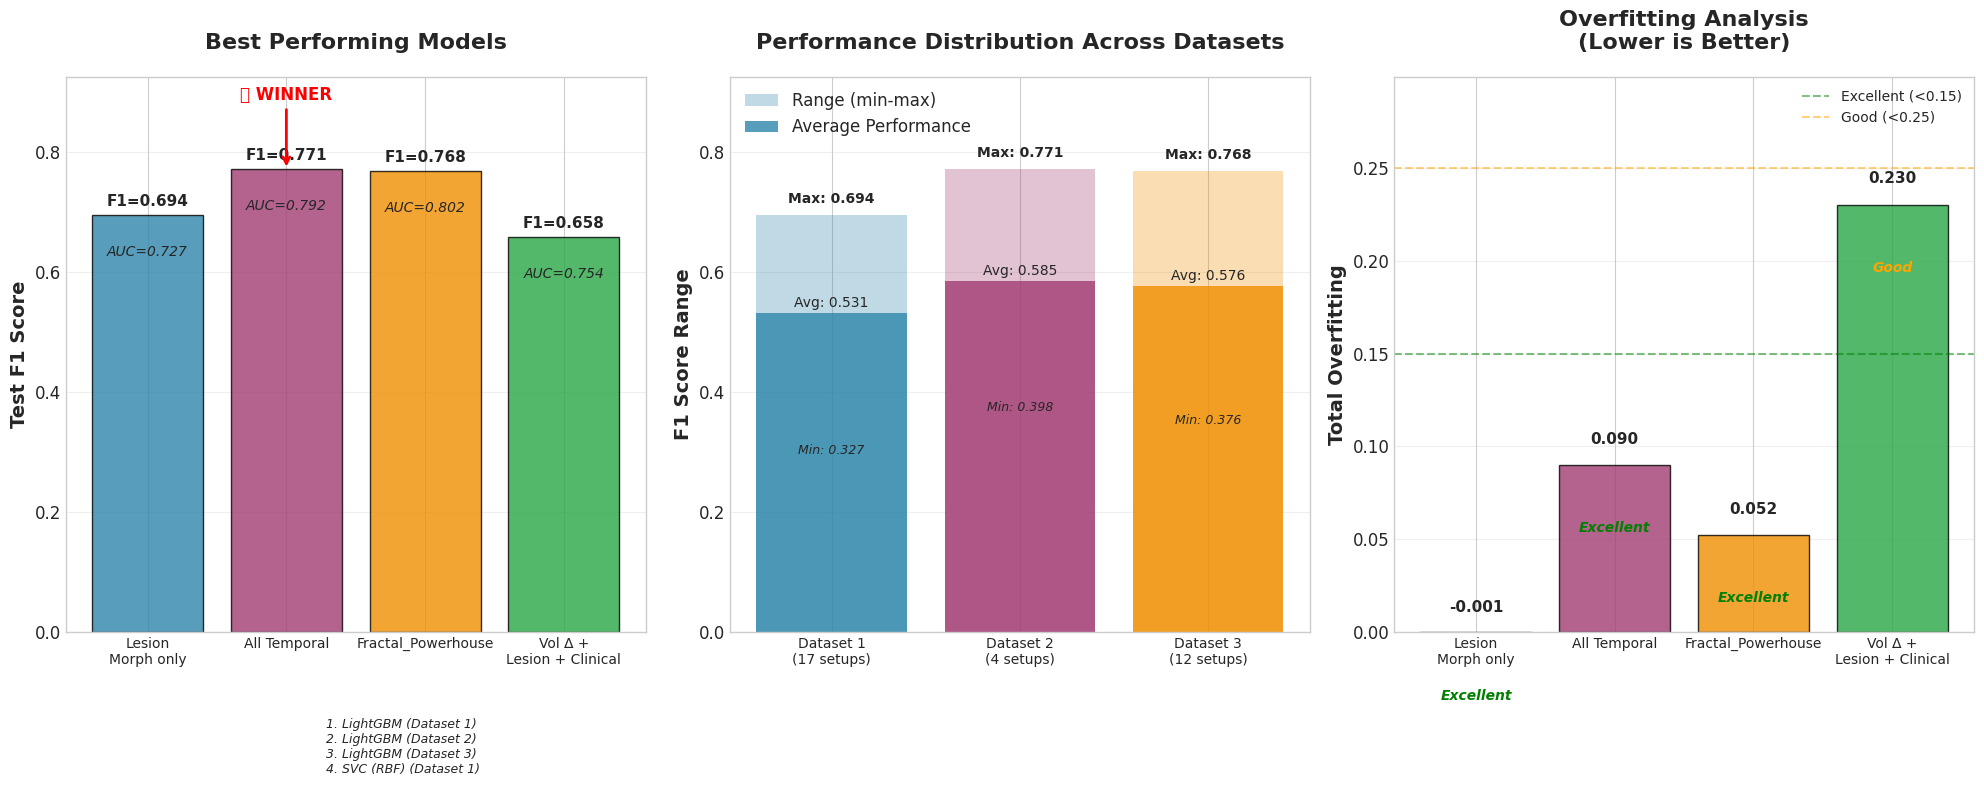

Chart saved as 'supervisor_comparison.png'
DATA-DRIVEN SUMMARY FOR SUPERVISOR

🏆 BEST RESULTS (automatically detected):
1. Lesion Morph only: F1=0.694, AUC=0.727
   Model: LightGBM, Dataset: Dataset 1
   Overfitting: -0.001
2. All Temporal: F1=0.771, AUC=0.792
   Model: LightGBM, Dataset: Dataset 2
   Overfitting: 0.090
3. Fractal_Powerhouse: F1=0.768, AUC=0.802
   Model: LightGBM, Dataset: Dataset 3
   Overfitting: 0.052
4. Vol ∆ + Lesion + Clinical: F1=0.658, AUC=0.754
   Model: SVC (RBF), Dataset: Dataset 1
   Overfitting: 0.230

🎯 KEY FINDINGS:
• Best Performance: All Temporal (F1=0.771)
• Best Generalization: Lesion Morph only (overfitting=-0.001)
• Performance improvement: 17.1% over Vol Δ + Lesion + Clinical

Rigorous, data-driven chart ready to send! 📊


<Figure size 2000x800 with 0 Axes>

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set professional plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

def load_and_analyze_data():
    """Load and analyze all three experimental datasets"""
    
    # Load the actual CSV files
    df_traditional = pd.read_csv('ablation_results_1.csv')
    df_temporal = pd.read_csv('ablation_results_corrected.csv')  
    df_strategic = pd.read_csv('ablation_results_fractal_only.csv')
    
    # Find the single best performer from each dataset
    best_performers = []
    
    # Best from first dataset
    best_idx_1 = df_traditional['Test_F1'].idxmax()
    best_1 = df_traditional.loc[best_idx_1]
    best_performers.append({
        'setup': best_1['Setup'],
        'model': best_1['Model'],
        'test_f1': best_1['Test_F1'],
        'test_auc': best_1['Test_ROC_AUC'],
        'total_overfit': best_1['Total_Overfit'],
        'dataset': 'Dataset 1'
    })
    
    # Best from second dataset
    best_idx_2 = df_temporal['Test_F1'].idxmax()
    best_2 = df_temporal.loc[best_idx_2]
    best_performers.append({
        'setup': best_2['Setup'],
        'model': best_2['Model'],
        'test_f1': best_2['Test_F1'],
        'test_auc': best_2['Test_ROC_AUC'],
        'total_overfit': best_2['Total_Overfit'],
        'dataset': 'Dataset 2'
    })
    
    # Best from third dataset
    best_idx_3 = df_strategic['Test_F1'].idxmax()
    best_3 = df_strategic.loc[best_idx_3]
    best_performers.append({
        'setup': best_3['Setup'],
        'model': best_3['Model'],
        'test_f1': best_3['Test_F1'],
        'test_auc': best_3['Test_ROC_AUC'],
        'total_overfit': best_3['Total_Overfit'],
        'dataset': 'Dataset 3'
    })
    
    # Add the specific Vol Δ + Lesion + Clinical combination from first dataset
    vol_lesion_clinical = df_traditional[df_traditional['Setup'] == 'Vol ∆ + Lesion + Clinical']
    if len(vol_lesion_clinical) > 0:
        best_vlc = vol_lesion_clinical.loc[vol_lesion_clinical['Test_F1'].idxmax()]
        best_performers.append({
            'setup': best_vlc['Setup'],
            'model': best_vlc['Model'],
            'test_f1': best_vlc['Test_F1'],
            'test_auc': best_vlc['Test_ROC_AUC'],
            'total_overfit': best_vlc['Total_Overfit'],
            'dataset': 'Dataset 1'
        })
    
    return pd.DataFrame(best_performers), [df_traditional, df_temporal, df_strategic]

def create_supervisor_comparison():
    """Create comprehensive comparison chart for supervisor"""
    
    # Load and analyze data
    best_df, all_datasets = load_and_analyze_data()
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
    
    # Colors for each experiment
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#28A745']  # Blue, Purple, Orange, Green
    
    # Plot 1: Best F1 Performance - use actual setup names
    setup_labels = []
    for _, row in best_df.iterrows():
        # Use actual setup names, break long ones into multiple lines
        setup = row['setup']
        if len(setup) > 15:
            # Break long setup names
            words = setup.split(' ')
            if len(words) > 2:
                mid = len(words) // 2
                setup_label = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
            else:
                setup_label = setup
        else:
            setup_label = setup
        setup_labels.append(setup_label)
    
    bars1 = ax1.bar(range(len(best_df)), best_df['test_f1'], color=colors[:len(best_df)], 
                   alpha=0.8, edgecolor='black', linewidth=1)
    
    # Add value labels
    for i, (bar, row) in enumerate(zip(bars1, best_df.itertuples())):
        height = bar.get_height()
        # F1 score on top
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'F1={height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
        # AUC score below
        ax1.text(bar.get_x() + bar.get_width()/2., height - 0.05,
                f'AUC={row.test_auc:.3f}', ha='center', va='top', fontsize=10, style='italic')
    
    ax1.set_ylabel('Test F1 Score', fontsize=14, fontweight='bold')
    ax1.set_title('Best Performing Models', fontsize=16, fontweight='bold', pad=20)
    ax1.set_xticks(range(len(best_df)))
    ax1.set_xticklabels(setup_labels, fontsize=10)
    ax1.set_ylim(0, max(best_df['test_f1']) * 1.2)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add model info as text below the chart
    model_info = []
    for _, row in best_df.iterrows():
        model_info.append(f"{row['model']} ({row['dataset']})")
    
    # Add model info as subtitle
    fig.text(0.167, 0.02, '\n'.join([f"{i+1}. {info}" for i, info in enumerate(model_info)]), 
             fontsize=9, ha='left', va='bottom', style='italic')
    
    # Highlight winner
    winner_idx = best_df['test_f1'].idxmax()
    ax1.annotate('🏆 WINNER', xy=(winner_idx, best_df.iloc[winner_idx]['test_f1']), 
                xytext=(winner_idx, best_df.iloc[winner_idx]['test_f1'] * 1.15),
                ha='center', fontsize=12, fontweight='bold', color='red',
                arrowprops=dict(arrowstyle='->', color='red', lw=2))
    
    # Plot 2: Performance Range Analysis - use actual datasets
    datasets = ['ablation_results_1.csv', 'ablation_results_corrected.csv', 'ablation_results_fractal_only.csv']
    dataset_names = ['Dataset 1', 'Dataset 2', 'Dataset 3']
    
    range_data = []
    for i, (df, name) in enumerate(zip(all_datasets, dataset_names)):
        range_data.append({
            'dataset': name,
            'min': df['Test_F1'].min(),
            'mean': df['Test_F1'].mean(), 
            'max': df['Test_F1'].max(),
            'unique_setups': df['Setup'].nunique()
        })
    
    range_df = pd.DataFrame(range_data)
    x_pos = np.arange(len(range_df))
    
    # Create range visualization
    ax2.bar(x_pos, range_df['max'], color=colors[:len(range_df)], alpha=0.3, label='Range (min-max)')
    ax2.bar(x_pos, range_df['mean'], color=colors[:len(range_df)], alpha=0.8, label='Average Performance')
    
    # Add value labels
    for i, row in range_df.iterrows():
        ax2.text(i, row['max'] + 0.02, f'Max: {row["max"]:.3f}', ha='center', fontweight='bold', fontsize=10)
        ax2.text(i, row['mean'] + 0.01, f'Avg: {row["mean"]:.3f}', ha='center', fontsize=10)
        ax2.text(i, row['min'] - 0.03, f'Min: {row["min"]:.3f}', ha='center', fontsize=9, style='italic')
    
    ax2.set_ylabel('F1 Score Range', fontsize=14, fontweight='bold')
    ax2.set_title('Performance Distribution Across Datasets', fontsize=16, fontweight='bold', pad=20)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'{row["dataset"]}\n({row["unique_setups"]} setups)' for _, row in range_df.iterrows()], fontsize=10)
    ax2.set_ylim(0, range_df['max'].max() * 1.2)
    ax2.grid(axis='y', alpha=0.3)
    ax2.legend(loc='upper left')
    
    # Plot 3: Overfitting Analysis
    bars3 = ax3.bar(range(len(best_df)), best_df['total_overfit'], color=colors[:len(best_df)], 
                   alpha=0.8, edgecolor='black', linewidth=1)
    
    # Add labels and assessments
    for i, (bar, row) in enumerate(zip(bars3, best_df.itertuples())):
        height = bar.get_height()
        # Overfitting value
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # Assessment
        if height < 0.15:
            assessment, color = "Excellent", 'green'
        elif height < 0.25:
            assessment, color = "Good", 'orange'
        else:
            assessment, color = "Moderate", 'red'
            
        ax3.text(bar.get_x() + bar.get_width()/2., height - 0.03,
                assessment, ha='center', va='top', fontsize=10, 
                style='italic', color=color, fontweight='bold')
    
    # Reference lines
    ax3.axhline(y=0.15, color='green', linestyle='--', alpha=0.5, label='Excellent (<0.15)')
    ax3.axhline(y=0.25, color='orange', linestyle='--', alpha=0.5, label='Good (<0.25)')
    
    ax3.set_ylabel('Total Overfitting', fontsize=14, fontweight='bold')
    ax3.set_title('Overfitting Analysis\n(Lower is Better)', fontsize=16, fontweight='bold', pad=20)
    ax3.set_xticks(range(len(best_df)))
    ax3.set_xticklabels(setup_labels, fontsize=10)
    ax3.set_ylim(0, max(best_df['total_overfit']) * 1.3)
    ax3.grid(axis='y', alpha=0.3)
    ax3.legend(loc='upper right', fontsize=10)
    
    # Highlight best generalization
    best_overfit_idx = best_df['total_overfit'].idxmin()
    ax3.annotate('🎯 BEST', xy=(best_overfit_idx, best_df.iloc[best_overfit_idx]['total_overfit']), 
                xytext=(best_overfit_idx, best_df.iloc[best_overfit_idx]['total_overfit'] + 0.08),
                ha='center', fontsize=12, fontweight='bold', color='green',
                arrowprops=dict(arrowstyle='->', color='green', lw=2))
    
    plt.tight_layout()
    
    # Adjust bottom margin to make room for model info
    plt.subplots_adjust(bottom=0.2)
    
    plt.show()
    
    # Save the figure
    plt.savefig('supervisor_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
    print("Chart saved as 'supervisor_comparison.png'")
    
    return fig, best_df

def print_summary_stats(best_df):
    """Print rigorous summary statistics"""
    
    print("="*60)
    print("DATA-DRIVEN SUMMARY FOR SUPERVISOR")
    print("="*60)
    
    print("\n🏆 BEST RESULTS (automatically detected):")
    for i, row in best_df.iterrows():
        print(f"{i+1}. {row['setup']}: F1={row['test_f1']:.3f}, AUC={row['test_auc']:.3f}")
        print(f"   Model: {row['model']}, Dataset: {row['dataset']}")
        print(f"   Overfitting: {row['total_overfit']:.3f}")
    
    winner = best_df.loc[best_df['test_f1'].idxmax()]
    best_overfit = best_df.loc[best_df['total_overfit'].idxmin()]
    
    print(f"\n🎯 KEY FINDINGS:")
    print(f"• Best Performance: {winner['setup']} (F1={winner['test_f1']:.3f})")
    print(f"• Best Generalization: {best_overfit['setup']} (overfitting={best_overfit['total_overfit']:.3f})")
    
    # Compare best vs Vol Δ + Lesion + Clinical if it exists
    vlc_rows = best_df[best_df['setup'] == 'Vol ∆ + Lesion + Clinical']
    if len(vlc_rows) > 0:
        vlc_f1 = vlc_rows.iloc[0]['test_f1']
        improvement = ((winner['test_f1'] / vlc_f1) - 1) * 100
        print(f"• Performance improvement: {improvement:.1f}% over Vol Δ + Lesion + Clinical")

# Run the analysis
if __name__ == "__main__":
    print("Creating data-driven supervisor comparison chart...")
    fig, best_df = create_supervisor_comparison()
    print_summary_stats(best_df)
    print("\nRigorous, data-driven chart ready to send! 📊")

# Deeplearning Models for the Ablation Study

In [64]:
from torch import nn
import torch
from skorch.net import NeuralNet

# Patch NeuralNet.__doc__ to avoid AttributeError in NeuralNetClassifier
if NeuralNet.__doc__ is None:
    NeuralNet.__doc__ = "Temporary docstring to avoid AttributeError in NeuralNetClassifier."

from skorch.classifier import NeuralNetClassifier
from skorch.callbacks import EarlyStopping

#####################################
# 🔹 Simple MLP Model with Tunable Layers
#####################################
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 2)  # binary classification output
        )

    def forward(self, x):
        return self.net(x)


#####################################
# 🔹 Simple ResNet for Tabular Data
#####################################
class ResNetTabular(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.block1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.shortcut = nn.Linear(hidden_dim, hidden_dim)

        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        identity = x
        out = self.block1(x)
        out += self.shortcut(identity)
        out = self.relu(out)
        return self.output(out)


#####################################
# 🔹 TabNet Wrapper
#####################################
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

class TabNetSklearn(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim=10, output_dim=2, **kwargs):
        self.model = TabNetClassifier(input_dim=input_dim, output_dim=output_dim, **kwargs)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)


AttributeError: 'NoneType' object has no attribute 'span'

In [92]:
## Dictionary for the three models

In [56]:
models = {
    "MLP": lambda input_dim: NeuralNetClassifier(
        module=SimpleMLP,
        module__input_dim=input_dim,
        max_epochs=100,
        lr=0.001,
        optimizer=torch.optim.Adam,
        criterion=nn.CrossEntropyLoss,
        callbacks=[EarlyStopping(patience=10)],
        device='cuda' if torch.cuda.is_available() else 'cpu',
        verbose=0
    ),
    "ResNet": lambda input_dim: NeuralNetClassifier(
        module=ResNetTabular,
        module__input_dim=input_dim,
        max_epochs=100,
        lr=0.001,
        optimizer=torch.optim.Adam,
        criterion=nn.CrossEntropyLoss,
        callbacks=[EarlyStopping(patience=10)],
        device='cuda' if torch.cuda.is_available() else 'cpu',
        verbose=0
    ),
    "TabNet": lambda input_dim: TabNetSklearn(
        input_dim=input_dim,
        output_dim=2,
        n_d=64,
        n_a=64,
        n_steps=5,
        verbose=0,
        seed=42,
        device_name='cuda' if torch.cuda.is_available() else 'cpu'
    )
}


# Ablation Study Results - Which combos are we doing (from Minimal -> to All Features)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

results_nn = []

for setup_name, features in tqdm(ablation_setups.items(), desc="Neural Net Ablation"):
    df_clean = df_train.dropna(subset=features + ["binary_response", "patient_id"])
    X = df_clean[features].values.astype(np.float32)
    y = df_clean["binary_response"].values.astype(np.int64)
    groups = df_clean["patient_id"]
    input_dim = X.shape[1]

    # Split data for fair test evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    for model_name, model_fn in models.items():
        print(f"Running {model_name} on setup: {setup_name}")
        
        if model_name == "TabNet":
            clf = model_fn(input_dim)
            clf.fit(X_train, y_train)
            y_train_pred = clf.predict(X_train)
            y_test_pred = clf.predict(X_test)
            y_test_prob = clf.predict_proba(X_test)[:, 1]
        else:
            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("clf", model_fn(input_dim))
            ])
            pipe.fit(X_train, y_train)
            y_train_pred = pipe.predict(X_train)
            y_test_pred = pipe.predict(X_test)
            y_test_prob = pipe.predict_proba(X_test)[:, 1]

        # Record results
        results_nn.append({
            "Setup": setup_name,
            "Model": model_name,
            "Train_F1": f1_score(y_train, y_train_pred, average='macro'),
            "Test_F1": f1_score(y_test, y_test_pred, average='macro'),
            "Test_ROC_AUC": roc_auc_score(y_test, y_test_prob),
            "Test_Accuracy": accuracy_score(y_test, y_test_pred),
            "Overfit_Gap": f1_score(y_train, y_train_pred, average='macro') - f1_score(y_test, y_test_pred, average='macro')
        })

# Convert to DataFrame
import pandas as pd
results_nn_df = pd.DataFrame(results_nn).sort_values("Test_F1", ascending=False)


Neural Net Ablation:   0%|          | 0/21 [00:00<?, ?it/s]

⚙️ Running MLP on setup: Clinical only
⚙️ Running ResNet on setup: Clinical only
⚙️ Running TabNet on setup: Clinical only


Neural Net Ablation:   5%|▍         | 1/21 [00:01<00:30,  1.52s/it]

⚙️ Running MLP on setup: Volume ∆ only
⚙️ Running ResNet on setup: Volume ∆ only


Neural Net Ablation:  10%|▉         | 2/21 [00:01<00:16,  1.18it/s]

⚙️ Running TabNet on setup: Volume ∆ only
⚙️ Running MLP on setup: Baseline Volume only
⚙️ Running ResNet on setup: Baseline Volume only


Neural Net Ablation:  14%|█▍        | 3/21 [00:02<00:10,  1.71it/s]

⚙️ Running TabNet on setup: Baseline Volume only
⚙️ Running MLP on setup: Top Morph only
⚙️ Running ResNet on setup: Top Morph only


Neural Net Ablation:  19%|█▉        | 4/21 [00:02<00:08,  2.11it/s]

⚙️ Running TabNet on setup: Top Morph only
⚙️ Running MLP on setup: Lesion Morph only
⚙️ Running ResNet on setup: Lesion Morph only
⚙️ Running TabNet on setup: Lesion Morph only


Neural Net Ablation:  24%|██▍       | 5/21 [00:02<00:07,  2.27it/s]

⚙️ Running MLP on setup: Baseline Morph only
⚙️ Running ResNet on setup: Baseline Morph only
⚙️ Running TabNet on setup: Baseline Morph only


Neural Net Ablation:  29%|██▊       | 6/21 [00:03<00:06,  2.18it/s]

⚙️ Running MLP on setup: Volume ∆ + Clinical
⚙️ Running ResNet on setup: Volume ∆ + Clinical
⚙️ Running TabNet on setup: Volume ∆ + Clinical


Neural Net Ablation:  33%|███▎      | 7/21 [00:03<00:06,  2.28it/s]

⚙️ Running MLP on setup: Volume ∆ + Baseline Volume
⚙️ Running ResNet on setup: Volume ∆ + Baseline Volume
⚙️ Running TabNet on setup: Volume ∆ + Baseline Volume


Neural Net Ablation:  38%|███▊      | 8/21 [00:04<00:05,  2.57it/s]

⚙️ Running MLP on setup: Volume ∆ + Lesion
⚙️ Running ResNet on setup: Volume ∆ + Lesion
⚙️ Running TabNet on setup: Volume ∆ + Lesion


Neural Net Ablation:  43%|████▎     | 9/21 [00:04<00:04,  2.82it/s]

⚙️ Running MLP on setup: Volume ∆ + Top Morph
⚙️ Running ResNet on setup: Volume ∆ + Top Morph
⚙️ Running TabNet on setup: Volume ∆ + Top Morph


Neural Net Ablation:  48%|████▊     | 10/21 [00:04<00:03,  3.03it/s]

⚙️ Running MLP on setup: Baseline Vol + Clinical
⚙️ Running ResNet on setup: Baseline Vol + Clinical
⚙️ Running TabNet on setup: Baseline Vol + Clinical


Neural Net Ablation:  52%|█████▏    | 11/21 [00:04<00:03,  3.16it/s]

⚙️ Running MLP on setup: Baseline Vol + Lesion
⚙️ Running ResNet on setup: Baseline Vol + Lesion
⚙️ Running TabNet on setup: Baseline Vol + Lesion


Neural Net Ablation:  57%|█████▋    | 12/21 [00:05<00:02,  3.25it/s]

⚙️ Running MLP on setup: Baseline Vol + Top Morph
⚙️ Running ResNet on setup: Baseline Vol + Top Morph
⚙️ Running TabNet on setup: Baseline Vol + Top Morph


Neural Net Ablation:  62%|██████▏   | 13/21 [00:05<00:02,  3.23it/s]

⚙️ Running MLP on setup: Top Morph + Clinical
⚙️ Running ResNet on setup: Top Morph + Clinical
⚙️ Running TabNet on setup: Top Morph + Clinical


Neural Net Ablation:  67%|██████▋   | 14/21 [00:05<00:02,  3.09it/s]

⚙️ Running MLP on setup: Lesion + Clinical
⚙️ Running ResNet on setup: Lesion + Clinical
⚙️ Running TabNet on setup: Lesion + Clinical


Neural Net Ablation:  71%|███████▏  | 15/21 [00:06<00:02,  2.82it/s]

⚙️ Running MLP on setup: Baseline Morph + Clinical
⚙️ Running ResNet on setup: Baseline Morph + Clinical
⚙️ Running TabNet on setup: Baseline Morph + Clinical


Neural Net Ablation:  76%|███████▌  | 16/21 [00:06<00:01,  2.83it/s]

⚙️ Running MLP on setup: Vol ∆ + Baseline Vol + Top Morph
⚙️ Running ResNet on setup: Vol ∆ + Baseline Vol + Top Morph
⚙️ Running TabNet on setup: Vol ∆ + Baseline Vol + Top Morph


Neural Net Ablation:  81%|████████  | 17/21 [00:06<00:01,  2.85it/s]

⚙️ Running MLP on setup: Vol ∆ + Lesion + Clinical
⚙️ Running ResNet on setup: Vol ∆ + Lesion + Clinical
⚙️ Running TabNet on setup: Vol ∆ + Lesion + Clinical


Neural Net Ablation:  86%|████████▌ | 18/21 [00:07<00:01,  2.78it/s]

⚙️ Running MLP on setup: Baseline Vol + Lesion + Top Morph
⚙️ Running ResNet on setup: Baseline Vol + Lesion + Top Morph
⚙️ Running TabNet on setup: Baseline Vol + Lesion + Top Morph


Neural Net Ablation:  90%|█████████ | 19/21 [00:07<00:00,  2.87it/s]

⚙️ Running MLP on setup: Top Morph + Lesion + Clinical
⚙️ Running ResNet on setup: Top Morph + Lesion + Clinical
⚙️ Running TabNet on setup: Top Morph + Lesion + Clinical


Neural Net Ablation:  95%|█████████▌| 20/21 [00:08<00:00,  2.81it/s]

⚙️ Running MLP on setup: All features
⚙️ Running ResNet on setup: All features
⚙️ Running TabNet on setup: All features


Neural Net Ablation: 100%|██████████| 21/21 [00:08<00:00,  2.49it/s]


ModuleNotFoundError: No module named 'ace_tools'

In [65]:
display(results_nn_df)

results_df["Model_Type"] = "Classical"
results_nn_df["Model_Type"] = "Neural"

# Fill missing columns in results_nn_df with NaNs to match results_df
for col in results_df.columns:
    if col not in results_nn_df.columns:
        results_nn_df[col] = np.nan

# (Optional) If some cols exist in nn_df but not in results_df, you can drop or reorder
results_nn_df = results_nn_df[results_df.columns]


,Setup,Model,Train_F1,Test_F1,Test_ROC_AUC,Test_Accuracy,Overfit_Gap
61,All features,ResNet,0.714005,0.796429,0.804487,0.842105,-0.082424
40,Top Morph + Clinical,ResNet,0.632976,0.734796,0.830128,0.815789,-0.101820
19,Volume ∆ + Clinical,ResNet,0.676724,0.734796,0.778846,0.815789,-0.058071
58,Top Morph + Lesion + Clinical,ResNet,0.683230,0.636015,0.830128,0.736842,0.047214
39,Top Morph + Clinical,MLP,0.619675,0.626230,0.868590,0.763158,-0.006554
...,...,...,...,...,...,...,...
8,Baseline Volume only,TabNet,0.307429,0.318996,0.474359,0.342105,-0.011568
50,Vol ∆ + Baseline Vol + Top Morph,TabNet,0.373183,0.285017,0.368590,0.289474,0.088166
20,Volume ∆ + Clinical,TabNet,0.253589,0.281935,0.519231,0.342105,-0.028346
59,Top Morph + Lesion + Clinical,TabNet,0.241393,0.281935,0.641026,0.342105,-0.040542


In [66]:
combined_df = pd.concat([results_df, results_nn_df], ignore_index=True)
# View top-performing models overall
display(combined_df.sort_values("Test_F1", ascending=False))

# Or group by Model_Type to compare classes vs neural nets
display(combined_df.groupby("Model_Type").mean(numeric_only=True))


,Setup,Model,F1_macro,F1_std,Train_F1,ROC_AUC,Accuracy,Test_F1,Test_ROC_AUC,Test_Accuracy,Overfit_Gap,Model_Type
0,Volume ∆ + Top Morph,RandomForest,0.605777,0.124313,0.879032,0.922149,0.840426,0.852459,0.831481,0.808511,0.273256,Classical
1,Top Morph + Lesion + Clinical,XGBoost,0.651000,0.120164,0.952030,0.992706,0.930851,0.830769,0.803704,0.765957,0.301029,Classical
2,Top Morph only,XGBoost,0.570103,0.100136,0.981132,0.999602,0.973404,0.830769,0.818519,0.765957,0.411029,Classical
3,Top Morph + Lesion + Clinical,LightGBM,0.631611,0.100625,0.899628,0.953581,0.856383,0.818182,0.861111,0.744681,0.268018,Classical
4,Top Morph + Clinical,SVC (RBF),0.665480,0.031715,0.847328,0.861936,0.787234,0.813559,0.759259,0.765957,0.181848,Classical
...,...,...,...,...,...,...,...,...,...,...,...,...
163,Baseline Volume only,TabNet,NaN,NaN,0.307429,NaN,NaN,0.318996,0.474359,0.342105,-0.011568,Neural
164,Vol ∆ + Baseline Vol + Top Morph,TabNet,NaN,NaN,0.373183,NaN,NaN,0.285017,0.368590,0.289474,0.088166,Neural
165,Volume ∆ + Clinical,TabNet,NaN,NaN,0.253589,NaN,NaN,0.281935,0.519231,0.342105,-0.028346,Neural
166,Top Morph + Lesion + Clinical,TabNet,NaN,NaN,0.241393,NaN,NaN,0.281935,0.641026,0.342105,-0.040542,Neural


,F1_macro,F1_std,Train_F1,ROC_AUC,Accuracy,Test_F1,Test_ROC_AUC,Test_Accuracy,Overfit_Gap
Model_Type,,,,,,,,,
Classical,0.580541,0.092812,0.851667,0.873474,0.810081,0.724524,0.696085,0.651469,0.271126
Neural,NaN,NaN,0.490298,NaN,NaN,0.481548,0.629223,0.638680,0.008750
